# Machine Learning for Weather Forecasts

This notebook forecasts the average temperature using traditional machine learning algorithms: Auto Regressive Integrated Moving Average models (ARIMA). It is a step-by-step guide on how to use ARIMA models in Python and apply it to real-world data.

Dataset can be fount on [Berkeley Earth data](http://berkeleyearth.org/data/) page. Berkeley Earth Surface Temperature Study combines 1.6 billion temperature reports from 16 pre-existing archives. It is nicely packaged and allows for slicing into interesting subsets (for example by country). They publish the source data and the code for the transformations they applied. They also use methods that allow weather observations from shorter time series to be included, meaning fewer observations need to be thrown away.

In [1]:
# import necessary libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from itertools import product
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Dataset Exploration

In [3]:
data = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')

In [4]:
# show first few records
data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [5]:
# show a concise summary of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB


# Preprocessing, Advanced Visualisation and Stationarity

Let's isolate Toronto and consider the data of this city to be our dataset. The target is the AverageTemperature column, that is the Average Temperature for that specific month. We have data from 1743 to 2013.

In [6]:
toronto_data = data[data['City'] == 'Toronto']

In [7]:
toronto_data.head(7)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
229690,1743-11-01,-0.106,1.905,Toronto,Canada,44.20N,80.50W
229691,1743-12-01,NaN,NaN,Toronto,Canada,44.20N,80.50W
229692,1744-01-01,NaN,NaN,Toronto,Canada,44.20N,80.50W
229693,1744-02-01,NaN,NaN,Toronto,Canada,44.20N,80.50W
229694,1744-03-01,NaN,NaN,Toronto,Canada,44.20N,80.50W
229695,1744-04-01,5.892,2.249,Toronto,Canada,44.20N,80.50W
229696,1744-05-01,12.050,1.830,Toronto,Canada,44.20N,80.50W


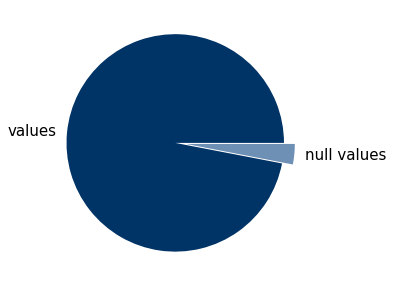

In [8]:
# display NaN values with a pie chart
plt.figure(figsize = (5, 5))
explodes = (0, 0.1)
plt.pie(data[data['City'] == 'Toronto'].AverageTemperature.isna().value_counts(),
        explode = explodes,
        startangle = 0,
        colors = ['#003366', '#6E90B5'],
        labels = ['values', 'null values'],
        textprops = {'fontsize': 15});

Let's fill the missing values with the previous ones.

In [9]:
toronto_data['AverageTemperature'] = toronto_data.AverageTemperature.fillna(method = 'bfill')
toronto_data['AverageTemperatureUncertainty'] = toronto_data.AverageTemperatureUncertainty.fillna(method = 'bfill')

In [10]:
# check missing values
toronto_data.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
229690,1743-11-01,-0.106,1.905,Toronto,Canada,44.20N,80.50W
229691,1743-12-01,5.892,2.249,Toronto,Canada,44.20N,80.50W
229692,1744-01-01,5.892,2.249,Toronto,Canada,44.20N,80.50W
229693,1744-02-01,5.892,2.249,Toronto,Canada,44.20N,80.50W
229694,1744-03-01,5.892,2.249,Toronto,Canada,44.20N,80.50W


The 'dt' column identifies the year and the month. It is better to convert this column into a datetime object and to explicitly identify the year and the month in two different columns.

In [11]:
toronto_data = toronto_data.reset_index()
toronto_data = toronto_data.drop(columns = ['index'])
toronto_data.dt = pd.to_datetime(toronto_data.dt)

In [12]:
YEAR = []
MONTH = []
DAY = []
WEEKDAY = []
for i in range(len(toronto_data)):
    WEEKDAY.append(toronto_data.dt[i].weekday())
    DAY.append(toronto_data.dt[i].day)
    MONTH.append(toronto_data.dt[i].month)
    YEAR.append(toronto_data.dt[i].year)

In [13]:
toronto_data['Year'] = YEAR
toronto_data['Month'] = MONTH
toronto_data['Day'] = DAY 
toronto_data['Weekday'] = WEEKDAY

In [14]:
change_year_index = []
change_year = []
year_list = toronto_data['Year'].tolist()
for year in range(0, len(year_list) - 1):
    if year_list[year] != year_list[year + 1]:
        change_year.append(year_list[year + 1])
        change_year_index.append(year + 1)

In [15]:
toronto_data.loc[change_year_index].head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Year,Month,Day,Weekday
2,1744-01-01,5.892,2.249,Toronto,Canada,44.20N,80.50W,1744,1,1,2
14,1745-01-01,-7.625,2.182,Toronto,Canada,44.20N,80.50W,1745,1,1,4
26,1746-01-01,-8.613,2.057,Toronto,Canada,44.20N,80.50W,1746,1,1,5
38,1747-01-01,-8.613,2.057,Toronto,Canada,44.20N,80.50W,1747,1,1,6
50,1748-01-01,-8.613,2.057,Toronto,Canada,44.20N,80.50W,1748,1,1,0


Now we can to obtain a scatter plot like this,

In [16]:
x_ticks_year_list = np.linspace(min(year_list), max(year_list), 10).astype(int)
change_year_index = np.array(change_year_index)
x_ticks_year_index = []
for i in range(1, len(x_ticks_year_list)):
    x_ticks_year_index.append(change_year_index[np.where(np.array(change_year) == x_ticks_year_list[i])][0])

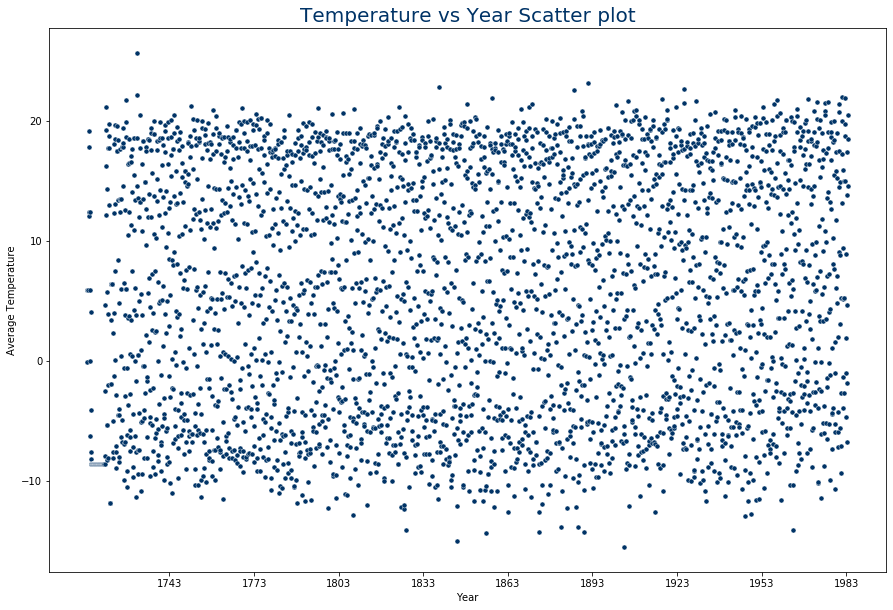

In [17]:
plt.figure(figsize = (15, 10))
sns.scatterplot(x = toronto_data.index, y = toronto_data.AverageTemperature, s = 25, color = '#003366')
plt.xticks(x_ticks_year_index, x_ticks_year_list)
plt.title('Temperature vs Year Scatter plot', color = '#003366', fontsize = 20)
plt.xlabel('Year')
plt.ylabel('Average Temperature');

But it's hard to read, so it's better to do something better. We can describe three functions:
1. __get_timeseries(start_year,end_year)__:  extracts the portion of the dataset between the two years 
1. __plot_timeseries(start_year,end_year)__:  plots the timeseries extracted in get_timeseries in a readable way
1. __plot_from_data(data, time, display_options)__:  plots the data (AverageTemperature) wrt the time (dt) in a readable way. The display options permit to display the ticks, change the colors, set the label


In [18]:
# last_year_data = toronto_data[toronto_data.Year >= 2010].reset_index().drop(columns = ['index'])
# P = np.linspace(0,len(last_year_data)-1,5).astype(int)

In [19]:
def get_timeseries(start_year,end_year):
    last_year_data = toronto_data[(toronto_data.Year >= start_year) & (toronto_data.Year <= end_year)].reset_index().drop(columns = ['index'])
    return last_year_data

In [20]:
def plot_timeseries(start_year,end_year):
    last_year_data = get_timeseries(start_year,end_year)
    P = np.linspace(0, len(last_year_data) - 1, 5).astype(int)
    plt.plot(last_year_data.AverageTemperature, marker = '.', color = '#003366')
    plt.xticks(np.arange(0, len(last_year_data), 1)[P], last_year_data.dt.loc[P])
    plt.xlabel('Date (Y/M/D)')
    plt.ylabel('Average Temperature')

In [21]:
def plot_from_data(data, time, c = '#003366', with_ticks = True, label = None):
    time = time.tolist()
    data = np.array(data.tolist())
    P = np.linspace(0, len(data) - 1, 5).astype(int)
    time = np.array(time)
    if label == None:
        plt.plot(data, marker = '.', color = c)
    else:
        plt.plot(data, marker = '.', color = c, label = label)
    if with_ticks == True:
        plt.xticks(np.arange(0, len(data), 1)[P], time[P])
    plt.xlabel('Date (Y/M/D)')
    plt.ylabel('Average Temperature')

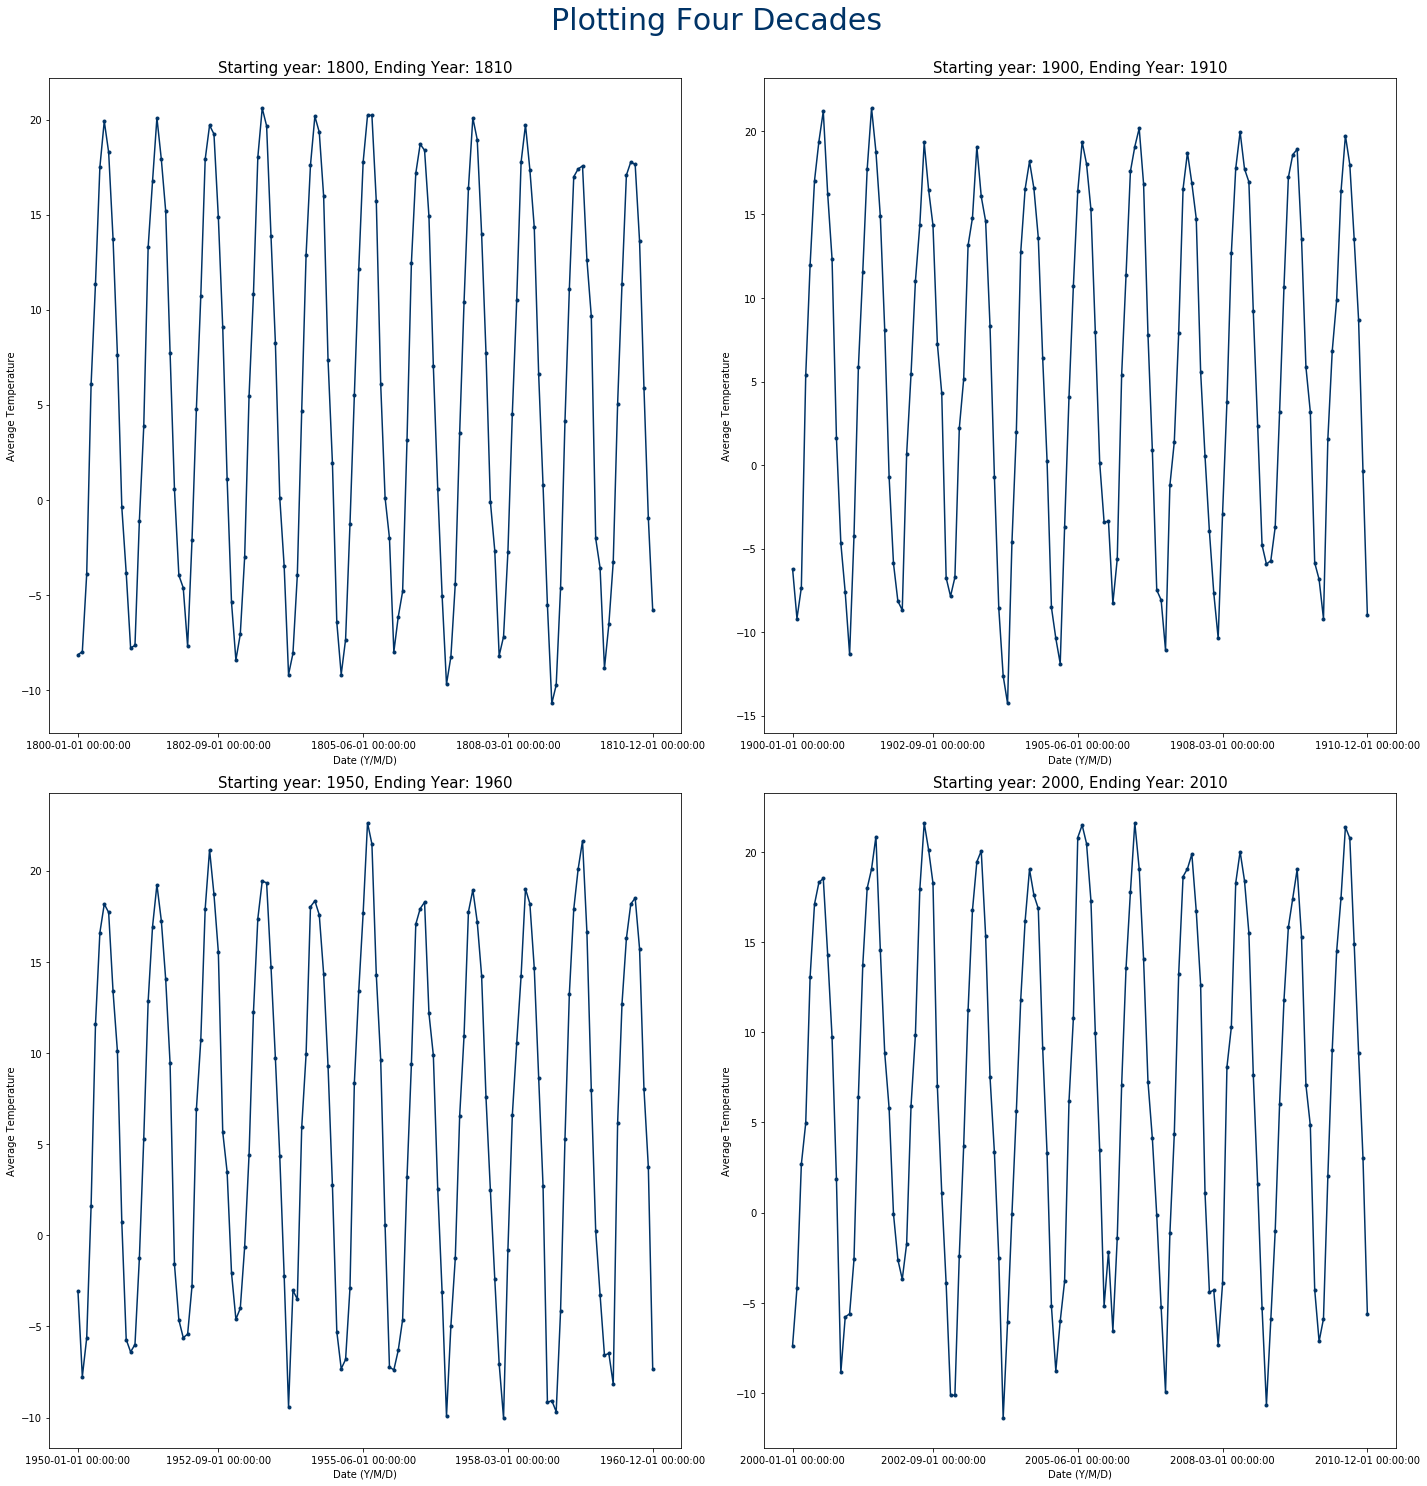

In [22]:
plt.figure(figsize = (20, 20))
# plt.title(figure_title, )
plt.suptitle('Plotting Four Decades', fontsize = 30, color = '#003366', y = 1.03)
plt.subplot(2, 2, 1)
plt.title('Starting year: 1800, Ending Year: 1810', fontsize = 15)
plot_timeseries(1800, 1810)
plt.subplot(2, 2, 2)
plt.title('Starting year: 1900, Ending Year: 1910', fontsize = 15)
plot_timeseries(1900, 1910)
plt.subplot(2, 2, 3)
plt.title('Starting year: 1950, Ending Year: 1960', fontsize = 15)
plot_timeseries(1950, 1960)
plt.subplot(2, 2, 4)
plt.title('Starting year: 2000, Ending Year: 2010', fontsize = 15)
plot_timeseries(2000, 2010)
plt.tight_layout();

When we use ARIMA models, we should be considering stationary time series. In order to check if the timeseries we are considering is stationary, we can check the correlation and autocorrelation plots.

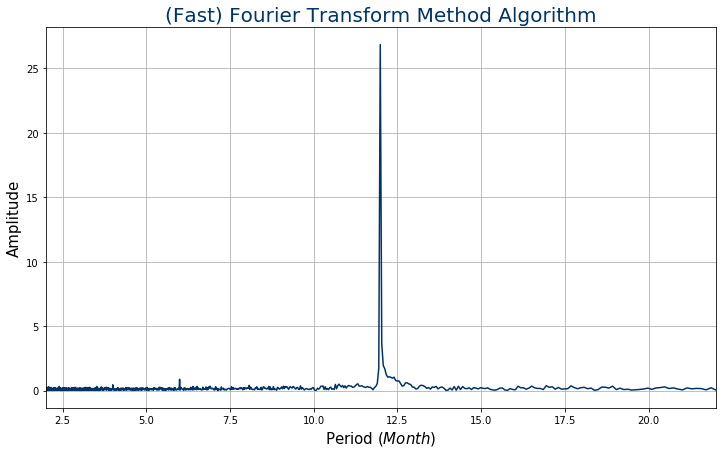

In [23]:
FFT = np.fft.fft(toronto_data.AverageTemperature)
FFT_abs = np.abs(FFT)
new_N = int(len(FFT)/2) 
f_nat = 1
new_X = np.linspace(0, f_nat/2, new_N, endpoint = True)
new_X = 1/new_X
plt.figure(figsize = (12, 7))
plt.plot(new_X, 2 * FFT_abs[0 : int(len(FFT)/2.)] / len(new_X), color = '#003366')
plt.xlabel('Period ($Month$)', fontsize = 15)
plt.ylabel('Amplitude', fontsize = 15)
plt.title('(Fast) Fourier Transform Method Algorithm', fontsize = 20, color = '#003366')
plt.grid(True)
plt.xlim(2, 22);

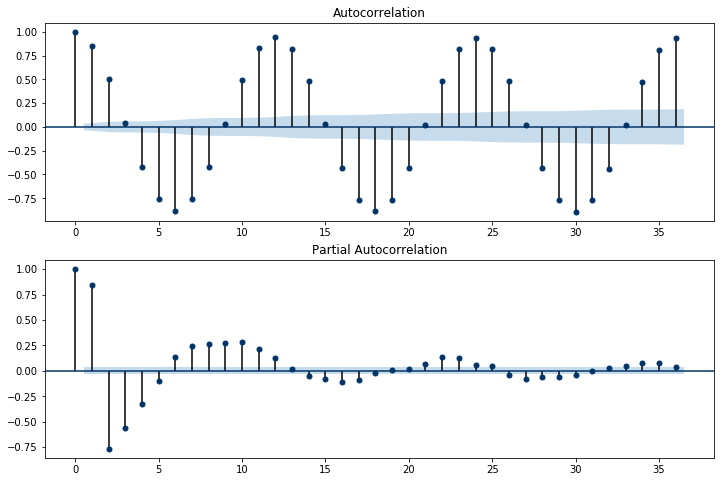

In [24]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(toronto_data.AverageTemperature, ax = ax1, color = '#003366')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(toronto_data.AverageTemperature, ax = ax2, color = '#003366')

So the timeseries is not stationary. Nonetheless, if we perform the AD Fuller Test on the entire dataset it tells us that the dataset is stationary.

In [25]:
result = adfuller(toronto_data.AverageTemperature)
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the entire dataset: -6.744031865695299
p-value: 3.067247874319735e-09
Critical Values:
	1%: -3.4323894324171813
	5%: -2.8624410979440333
	10%: -2.567249674462629


But it's true just because we are looking at the entire dataset. In fact, if we analyse a single decade, it is clear that the dataset is absolutely not stationary for the decade period of time.

In [26]:
result = adfuller(toronto_data.AverageTemperature[0:120])
print('ADF Statistic on the first decade: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the first decade: -2.1098135754789693
p-value: 0.24058686758129189
Critical Values:
	1%: -3.489589552580676
	5%: -2.887477210140433
	10%: -2.580604145195395


In order to take account of this non-stationarity, a differentiation term will be considered in the ARIMA models.

# Machine Learning Algorithms

Let's consider the 1992–2013 decade and plot it.

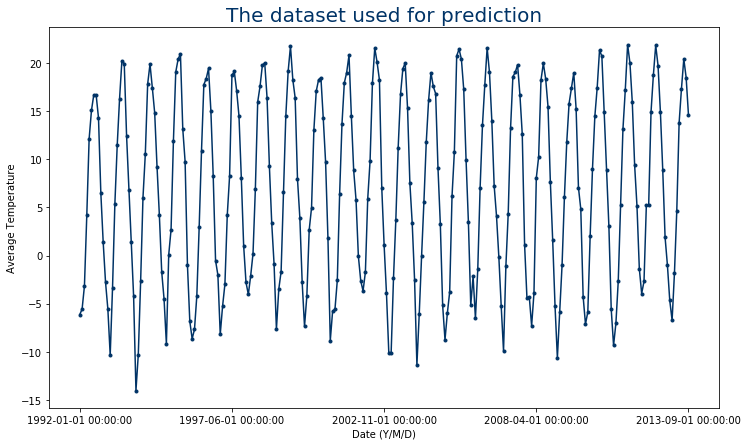

In [27]:
plt.figure(figsize = (12, 7))
plt.title('The dataset used for prediction', fontsize = 20, color = '#003366')
plot_timeseries(1992, 2013)

In [28]:
# perform the train/test split.
temp = get_timeseries(1992, 2013)
N = len(temp.AverageTemperature)
split = 0.95
training_size = round(split * N)
test_size = round((1 - split) * N)
series = temp.AverageTemperature[ : training_size]
date = temp.dt[ : training_size]
test_series = temp.AverageTemperature[ : test_size]
test_date = temp.dt[ : test_size]

In [29]:
test_date

0    1992-01-01
1    1992-02-01
2    1992-03-01
3    1992-04-01
4    1992-05-01
5    1992-06-01
6    1992-07-01
7    1992-08-01
8    1992-09-01
9    1992-10-01
10   1992-11-01
11   1992-12-01
12   1993-01-01
Name: dt, dtype: datetime64[ns]

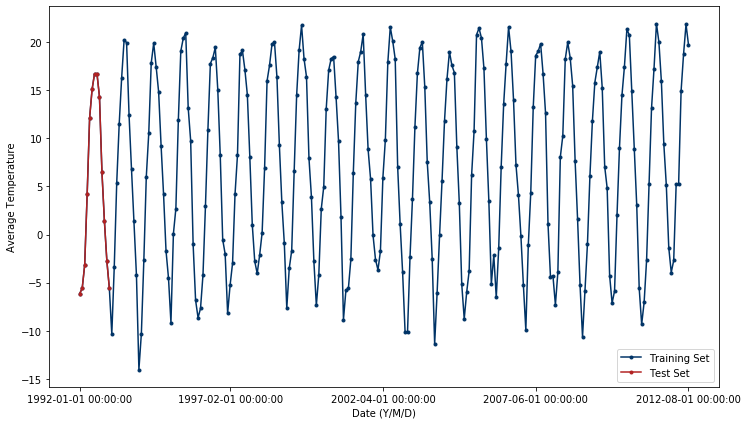

In [30]:
# plot the split
plt.figure(figsize = (12, 7))
plot_from_data(series, date, label = 'Training Set')
plot_from_data(test_series, test_date, 'firebrick', with_ticks = False, label = 'Test Set')
plt.legend();

In [31]:
test_series = temp.AverageTemperature[len(date)-1 : len(temp)]
test_date = temp.dt[len(date)-1 : len(temp)]

The machine learning algorithm we gonna apply are the ARIMA models. These are based on an optimisation procedure that adopts the Maximum Likelihood function.

In [32]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        model = SARIMAX(exog, order = order).fit(disp = -1)
        aic = model.aic
        results.append([order, model.aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    # sort in ascending order as lower AIC is better
    result_df = result_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)
    
    return result_df

The zero-differentiated ARIMA models are considered and evaluated using the AIC.

In [33]:
ps = range(0, 10, 1)
d = 0
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_0 = optimize_ARIMA(order_list, exog = series)

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
result_d_0.head()

,"(p, d, q)",AIC
0,"(6, 0, 8)",1053.968758
1,"(3, 0, 3)",1057.105818
2,"(3, 0, 6)",1057.546188
3,"(4, 0, 8)",1058.343096
4,"(4, 0, 7)",1058.956073


While the first-differentiated models are considered by using these lines:

In [35]:
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)

# create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_1 = optimize_ARIMA(order_list, exog = series)

  0%|          | 0/100 [00:00<?, ?it/s]

The total summary is highlighted with this function and it shows that the (2,1,9) model and the (2,1,4) model are the best ones.

In [36]:
result_d_1.head()

,"(p, d, q)",AIC
0,"(2, 1, 9)",1051.350733
1,"(2, 1, 4)",1051.774933
2,"(2, 1, 6)",1052.923496
3,"(7, 1, 7)",1053.387038
4,"(4, 1, 4)",1053.687669


As it is possible to see the statistical summary values are almost identical.

In [37]:
final_result = result_d_0.append(result_d_1)
best_models = final_result.sort_values(by = 'AIC', ascending = True).reset_index(drop = True).head()
best_model_params_0 = best_models[best_models.columns[0]][0]
best_model_params_1 = best_models[best_models.columns[0]][1]

In [38]:
best_model_0 = SARIMAX(series, order = best_model_params_0).fit()
print(best_model_0.summary())
best_model_1 = SARIMAX(series, order = best_model_params_1).fit()
print(best_model_1.summary())

                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                  248
Model:               SARIMAX(2, 1, 9)   Log Likelihood                -513.675
Date:                Sun, 29 Aug 2021   AIC                           1051.351
Time:                        17:47:48   BIC                           1093.463
Sample:                             0   HQIC                          1068.306
                                - 248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7320      0.000   5712.865      0.000       1.731       1.733
ar.L2         -1.0000      0.000  -9109.755      0.000      -1.000      -1.000
ma.L1         -2.5060      0.403     -6.221      0.0

And the same thing happens between the statistical plots:<br>
- __Model (2, 1, 9)__

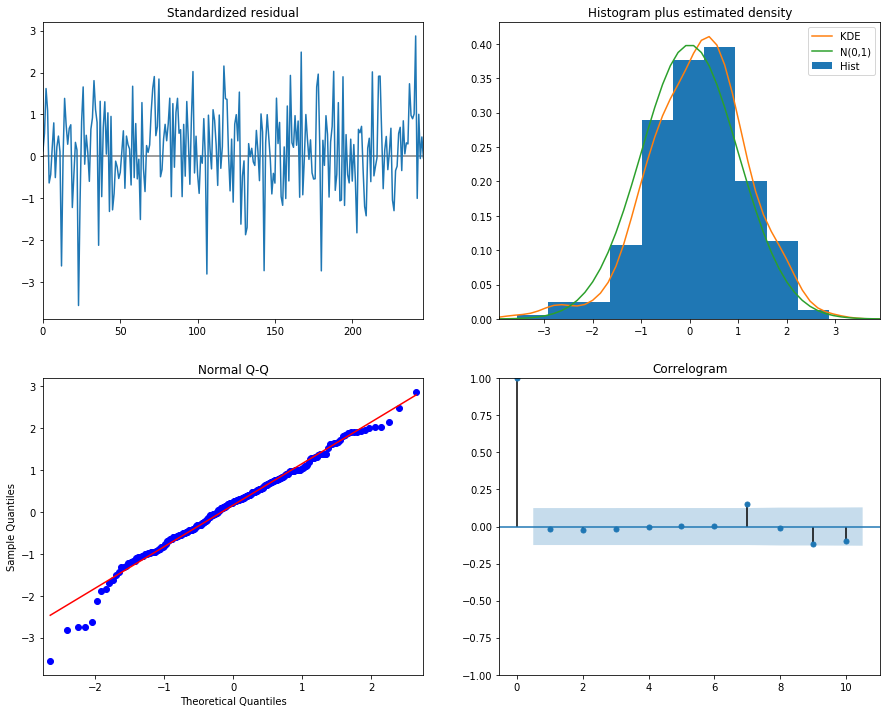

In [39]:
best_model_0.plot_diagnostics(figsize = (15, 12))
plt.show()

- __Model (2, 1, 4)__

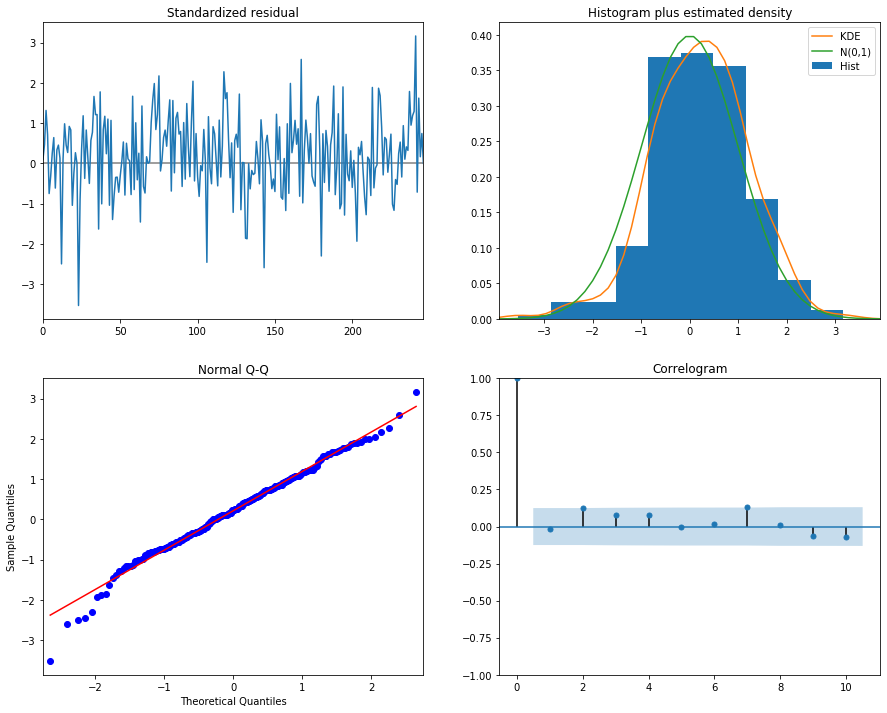

In [40]:
best_model_1.plot_diagnostics(figsize = (15, 12))
plt.show()

Nonetheless, it is preferable to use low index models both to avoid overfitting and reduce the computational stress on your computer. For this reason, the __(2, 1, 9)__ model has been considered.

# Forecasting

Let's plot the results of the forecasting operation:

In [41]:
fore_l= test_size - 1
forecast = best_model_0.get_prediction(start = training_size, end = training_size + fore_l)
forec = forecast.predicted_mean
ci = forecast.conf_int(alpha = 0.05)

s_forecast = best_model_1.get_prediction(start = training_size, end = training_size + fore_l)
s_forec = s_forecast.predicted_mean
s_ci = forecast.conf_int(alpha = 0.05)

In [42]:
test_series = temp.AverageTemperature[len(date)-1 : len(temp)]

In [43]:
error_test = toronto_data.loc[test_date[1:].index.tolist()].AverageTemperatureUncertainty
index_test = test_date[1:].index.tolist()
test_set = test_series[1:]

In [44]:
lower_test = test_set - error_test
upper_test = test_set + error_test

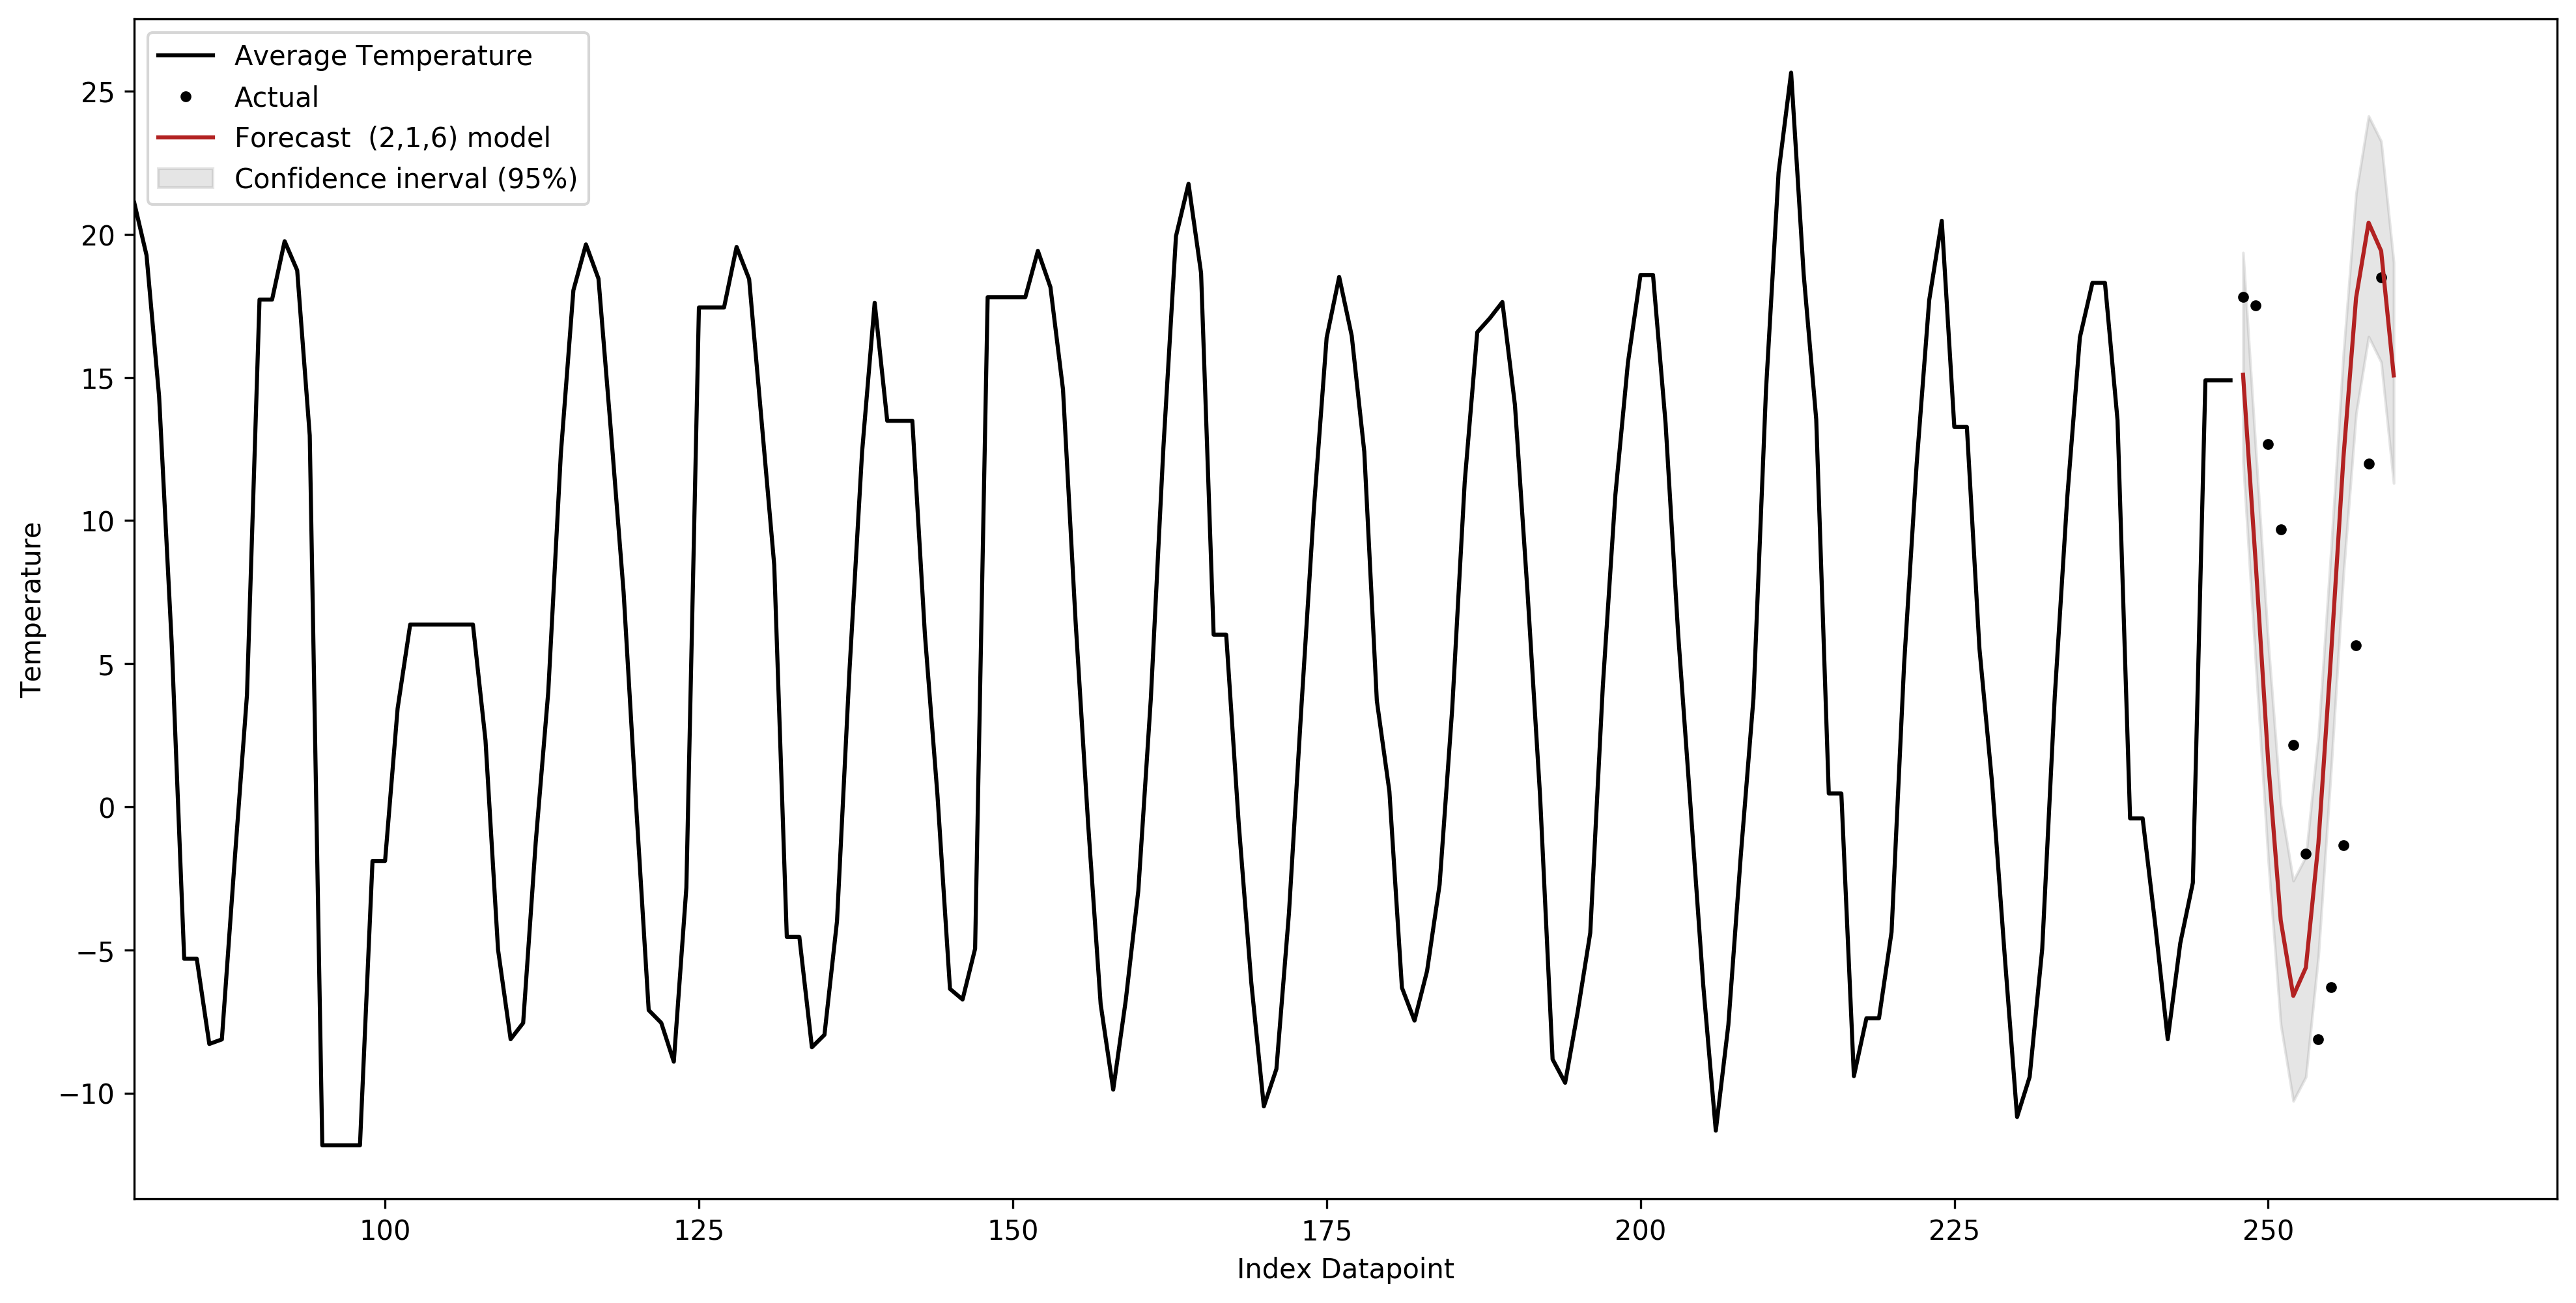

In [45]:
fig, ax = plt.subplots(figsize = (16, 8), dpi = 300)
x0 = toronto_data.AverageTemperature.index[0 : training_size]
x1 = toronto_data.AverageTemperature.index[training_size : training_size + fore_l + 1]
#ax.fill_between(forec, ci['lower Load'], ci['upper Load'])
plt.plot(x0, toronto_data.AverageTemperature[0:training_size],'k', label = 'Average Temperature')

plt.plot(toronto_data.AverageTemperature[training_size : training_size + fore_l], '.k', label = 'Actual')

forec = pd.DataFrame(forec, columns=['f'], index = x1)
#forec.f.plot(ax=ax,color = 'Darkorange',label = 'Forecast (d = 2)')
#ax.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')

s_forec = pd.DataFrame(s_forec, columns = ['f'], index = x1)
s_forec.f.plot(ax = ax, color = 'firebrick', label = 'Forecast  (2,1,6) model')
ax.fill_between(x1, s_ci['lower AverageTemperature'], s_ci['upper AverageTemperature'], alpha = 0.2, label = 'Confidence inerval (95%)', color = 'grey')


plt.legend(loc = 'upper left')
plt.xlim(80,)
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
plt.show()

And now let's consider the specific predicted zone with the correspondent Uncertainty (the one given by the dataset) and the confidence interval (given by the algorithm):

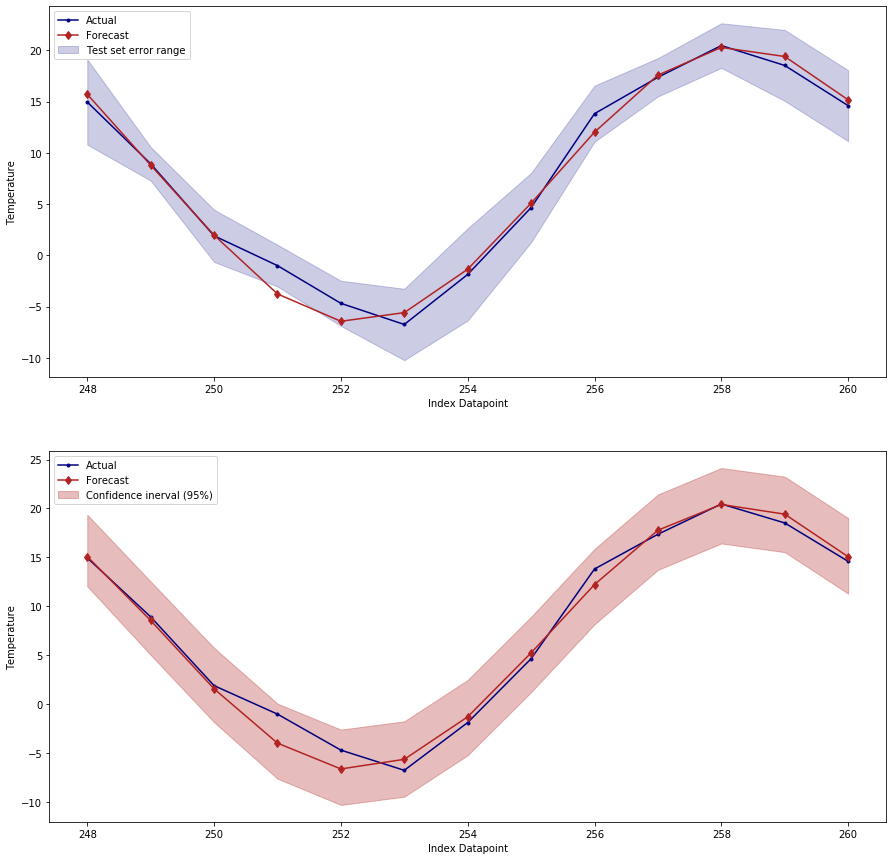

In [46]:
plt.figure(figsize = (15, 15))
plt.subplot(2, 1, 1)
plt.fill_between(x1, lower_test, upper_test, alpha = 0.2, label = 'Test set error range', color = 'navy')
plt.plot(test_set, marker = '.', label = 'Actual', color = 'navy')
plt.plot(forec, marker = 'd', label = 'Forecast', color = 'firebrick')
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
#plt.fill_between(x1, s_ci['lower AverageTemperature'], s_ci['upper AverageTemperature'],alpha=0.3, label = 'Confidence inerval (95%)',color='firebrick')
plt.legend()
plt.subplot(2, 1, 2)
#plt.fill_between(x1, lower_test, upper_test,alpha=0.2, label = 'Test set error range',color='navy')
plt.plot(test_set, marker = '.', label = 'Actual', color = 'navy')
plt.plot(s_forec, marker = 'd', label = 'Forecast', color = 'firebrick')
plt.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'], alpha = 0.3, label = 'Confidence inerval (95%)', color = 'firebrick')
plt.legend()
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature');

Finally, let's consider a more readable version of the plot:

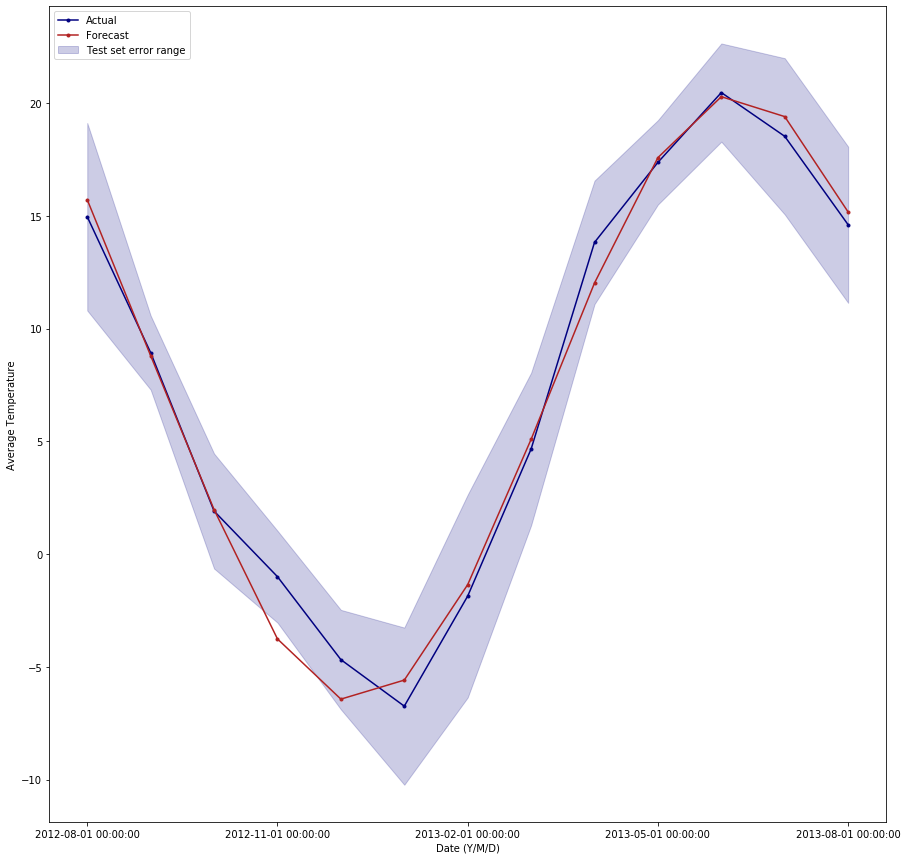

In [47]:
plt.figure(figsize = (15, 15))
plt.fill_between(np.arange(0, len(test_set), 1), lower_test, upper_test, alpha = 0.2, label = 'Test set error range', color = 'navy')
plot_from_data(test_set,test_date, c = 'navy', label = 'Actual')
plot_from_data(forec['f'], test_date, c = 'firebrick', label = 'Forecast')
plt.legend(loc = 2);

# Conclusions

These methods are extremely easy to adopt as they don’t require any specific computational power like Deep Learning methods (RNN, CNN, etc.)

Nonetheless, predictions perfectly fit in the error range designed by the dataset itself. It is important to consider that we only have examined monthly average values while it may be interesting to consider daily values too and have daily predictions.